In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
for root,dirs,files in os.walk('/kaggle/input/plant-disease-recognition-dataset'):
    if len(dirs) == 0 : 
        print(root)
        print(dirs)
        print(len(files))
    

/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Healthy
[]
20
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Rust
[]
20
/kaggle/input/plant-disease-recognition-dataset/Validation/Validation/Powdery
[]
20
/kaggle/input/plant-disease-recognition-dataset/Test/Test/Healthy
[]
50
/kaggle/input/plant-disease-recognition-dataset/Test/Test/Rust
[]
50
/kaggle/input/plant-disease-recognition-dataset/Test/Test/Powdery
[]
50
/kaggle/input/plant-disease-recognition-dataset/Train/Train/Healthy
[]
458
/kaggle/input/plant-disease-recognition-dataset/Train/Train/Rust
[]
434
/kaggle/input/plant-disease-recognition-dataset/Train/Train/Powdery
[]
430


In [3]:
train_path= '/kaggle/input/plant-disease-recognition-dataset/Train/Train'
val_path= '/kaggle/input/plant-disease-recognition-dataset/Validation/Validation'
test_path= '/kaggle/input/plant-disease-recognition-dataset/Test/Test'
data_gen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

train_gen = data_gen.flow_from_directory(train_path,target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training',  shuffle=True)
test_gen = data_gen.flow_from_directory(test_path,target_size=(224, 224), batch_size=32, class_mode='categorical', subset='training',  shuffle=False)


Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [4]:
train_gen.class_indices,test_gen.class_indices

({'Healthy': 0, 'Powdery': 1, 'Rust': 2},
 {'Healthy': 0, 'Powdery': 1, 'Rust': 2})

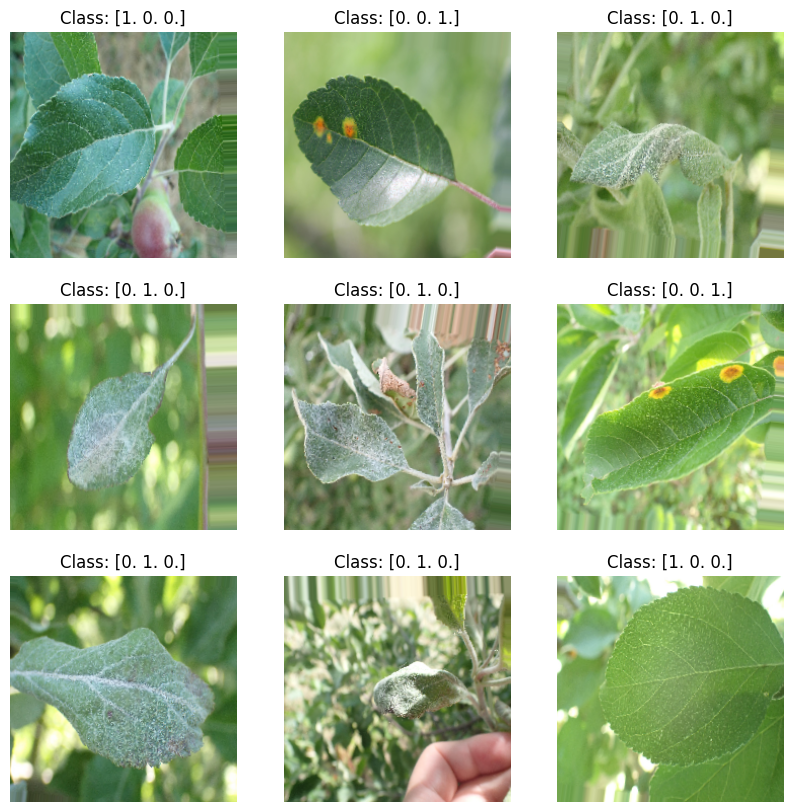

In [5]:
plt.figure(figsize=(10,10))
for images, labels in train_gen:
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i])
        plt.title('Class: {}'.format(labels[i]))
        plt.axis('off')
    break

In [6]:
pre_model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

for layer in pre_model.layers:
    layer.trainable = False

model1 = Sequential([
    pre_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model1.summary()

I0000 00:00:1757662788.019097      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757662788.019777      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [7]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.9621542940320232, 1: 1.0248062015503876, 2: 1.0153609831029187}

In [8]:
checkpoint1 = ModelCheckpoint('model1.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5,restore_best_weights=True)

In [9]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result1=model1.fit(train_gen,validation_data=test_gen,epochs=25,class_weight=class_weights,callbacks=[checkpoint1, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1757662799.629171     102 service.cc:148] XLA service 0x7c26c80115f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757662799.630376     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757662799.630404     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757662800.053560     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/42 ━━━━━━━━━━━━━━━━━━━━ 10:38 16s/step - accuracy: 0.5000 - loss: 1.2104

I0000 00:00:1757662811.156318     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5206 - loss: 2.2979
Epoch 1: val_accuracy improved from -inf to 0.81333, saving model to model1.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.5226 - loss: 2.2778 - val_accuracy: 0.8133 - val_loss: 0.5953
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7921 - loss: 0.5171
Epoch 2: val_accuracy did not improve from 0.81333
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7921 - loss: 0.5169 - val_accuracy: 0.7867 - val_loss: 0.4936
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8123 - loss: 0.4816
Epoch 3: val_accuracy did not improve from 0.81333
42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8124 - loss: 0.4813 - val_accuracy: 0.7867 - val_loss: 0.5192
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8304 - loss: 0.4119
Epoch 4: val_accuracy improved from 0.81333 to 0.85333, saving model to model1.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8305 - loss: 0.41

In [18]:
model2=Sequential([
    Conv2D(64,(3,3), activation='relu', padding='same',input_shape=(224,224,3)),
    MaxPooling2D(),
    Conv2D(128,(3,3) ,activation='relu', padding='same'),
    MaxPooling2D(),
    Conv2D(256,(3,3), activation='relu', padding='same'),
    MaxPooling2D(),
    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dropout(0.3),
    Dense(3,activation='softmax')
])
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,069,507 (99.45 MB)

 Trainable params: 26,069,507 (99.45 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint2 = ModelCheckpoint('model2.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [21]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result2=model2.fit(train_gen,validation_data=test_gen,epochs=25,class_weight=class_weights,callbacks=[checkpoint2, early_stopping])

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3524 - loss: 2.0582
Epoch 1: val_accuracy improved from -inf to 0.61333, saving model to model2.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.3532 - loss: 2.0418 - val_accuracy: 0.6133 - val_loss: 0.8705
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6101 - loss: 0.8549
Epoch 2: val_accuracy improved from 0.61333 to 0.80000, saving model to model2.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6120 - loss: 0.8522 - val_accuracy: 0.8000 - val_loss: 0.5202
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8376 - loss: 0.4516
Epoch 3: val_accuracy improved from 0.80000 to 0.88667, saving model to model2.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8377 - loss: 0.4516 - val_accuracy: 0.8867 - val_loss: 0.3526
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8490 - loss: 0.4652
Epoch 4: val_accuracy did not improve from 0.88667
42/42 ━━━━━━━━━━━━━━━━━━━━ 85

In [27]:
base_mnet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

for layer in base_mnet.layers:
    layer.trainable = False
    
model3=Sequential([base_mnet,
    GlobalAveragePooling2D(),    
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax') 
                  ])
model3.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
checkpoint3 = ModelCheckpoint('model3.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [29]:
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
result3=model3.fit(train_gen,validation_data=test_gen,epochs=25,class_weight=class_weights,callbacks=[checkpoint3, early_stopping])

Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7931 - loss: 0.5143
Epoch 1: val_accuracy improved from -inf to 0.92667, saving model to model3.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.7951 - loss: 0.5098 - val_accuracy: 0.9267 - val_loss: 0.1788
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9643 - loss: 0.1186
Epoch 2: val_accuracy improved from 0.92667 to 0.96000, saving model to model3.h5
42/42 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9643 - loss: 0.1184 - val_accuracy: 0.9600 - val_loss: 0.1683
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9631 - loss: 0.1037
Epoch 3: val_accuracy did not improve from 0.96000
42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9632 - loss: 0.1036 - val_accuracy: 0.9600 - val_loss: 0.1261
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9716 - loss: 0.0747
Epoch 4: val_accuracy did not improve from 0.96000
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9716 -

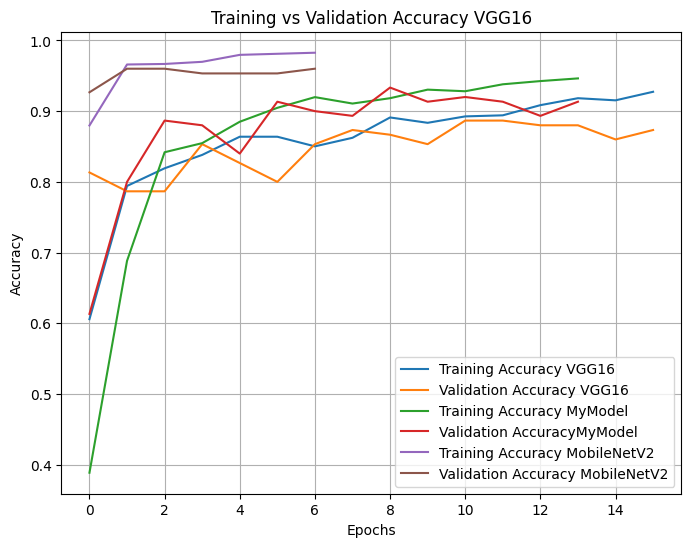

In [30]:
history1 = result1.history
history2 = result2.history
history3 = result3.history

plt.figure(figsize=(8,6))
plt.plot(history1['accuracy'], label='Training Accuracy VGG16')
plt.plot(history1['val_accuracy'], label='Validation Accuracy VGG16')
plt.plot(history2['accuracy'], label='Training Accuracy MyModel')
plt.plot(history2['val_accuracy'], label='Validation AccuracyMyModel')
plt.plot(history3['accuracy'], label='Training Accuracy MobileNetV2')
plt.plot(history3['val_accuracy'], label='Validation Accuracy MobileNetV2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy VGG16')
plt.legend()
plt.grid(True)
plt.show()